In [75]:
import os
import sys
sys.path.append("..")

import pandas as pd
import numpy as np

# Load the CSV file into a DataFrame
df = pd.read_csv('../SquadPlayerNames_IndianT20League - SquadData_AllTeams.csv')  # Replace with your actual CSV file name

# Define the range for random values
min_value = 10  # Replace with your desired minimum value
max_value = 100  # Replace with your desired maximum value

# Add a new column with random values within the specified range
df['Fantasy_Score'] = np.random.randint(min_value, max_value + 1, size=len(df))
df['probability'] = np.random.rand(len(df))

# Optionally, save the modified DataFrame back to a new CSV file
df.to_csv('SquadPlayerNames_IndianT20League - SquadData_AllTeams.csv', index=False)  # Replace with your desired output file name

# Print the first few rows of the modified DataFrame to confirm the new column
print(df)

    Credits Player Type           Player Name Team  Fantasy_Score  probability
0       8.0        BOWL          Harshit Rana  KKR             12     0.886473
1       6.5         BAT  Angkrish Raghuvanshi  KKR             71     0.250843
2       6.5        BOWL         Vaibhav Arora  KKR             87     0.005437
3       5.5          WK       Luvnith Sisodia  KKR             18     0.251287
4       6.0        BOWL       Mayank Markande  KKR             59     0.869826
5       6.0        BOWL       Chetan Sakariya  KKR             41     0.220412
6       7.5          WK    Rahmanullah Gurbaz  KKR             10     0.909102
7       6.5        BOWL       Spencer Johnson  KKR             57     0.092385
8       9.0        BOWL    Varun Chakravarthy  KKR             71     0.285561
9       8.0        BOWL         Anrich Nortje  KKR             10     0.817250
10      6.0         ALL   Anukul Sudhakar Roy  KKR             75     0.221807
11      7.5         ALL       Ramandeep Singh  KKR  

In [77]:
import pulp
import pandas as pd

def select_dream_team(players_df):

    # Create a copy of the DataFrame to avoid modifying the original
    players_df = players_df.copy()

    # Add 10 points to Fielders
    fielding_players = {
        ("Virat Kohli", "RCB"),
        ("Ajinkya Rahane", "KKR"), 
        ("Rovman Powell", "KKR"), 
        ("Philip Salt", "RCB"),  # Remove if he is the WK
        ("Liam Livingstone", "RCB"),  
        ("Tim David", "RCB"),   
        ("Andre Russell", "KKR"), 
        ("Rinku Singh", "KKR"), 
        ("Venkatesh Iyer", "KKR"),
        ("Quinton de Kock", "KKR")
    }

    # Add 10 points to WK
    players_df.loc[players_df["Player Type"] == "WK", "Fantasy_Score"] += 10
    
    # Boost Fantasy Score for specific players
    players_df.loc[
        players_df[["Player Name", "Team"]].apply(tuple, axis=1).isin(fielding_players), 
        "Fantasy_Score"
    ] += 10

    players = players_df.to_dict('records')
    prob = pulp.LpProblem("Dream_11_IPL_Team_Selection", pulp.LpMaximize)

    num_players = len(players)

    # Decision variables:
    x = pulp.LpVariable.dicts("Select", range(num_players), cat=pulp.LpBinary)
    c = pulp.LpVariable.dicts("Captain", range(num_players), cat=pulp.LpBinary)
    v = pulp.LpVariable.dicts("ViceCaptain", range(num_players), cat=pulp.LpBinary)

    # Constraints
    prob += pulp.lpSum([x[i] for i in range(num_players)]) == 11, "Total_players"
    prob += pulp.lpSum([players[i]["Credits"] * x[i] for i in range(num_players)]) <= 100, "Credit_limit"
    prob += pulp.lpSum([c[i] for i in range(num_players)]) == 1, "One_captain"
    prob += pulp.lpSum([v[i] for i in range(num_players)]) == 1, "One_vice_captain"

    for i in range(num_players):
        prob += c[i] <= x[i], f"Captain_if_selected_{i}"
        prob += v[i] <= x[i], f"ViceCaptain_if_selected_{i}"
        prob += c[i] + v[i] <= x[i], f"No_double_Designation_{i}"

    teams = set(player["Team"] for player in players)
        
    # At least 1 player from each Player Type category (except BOWL)
    for role in ["WK", "BAT", "ALL", "BOWL"]:
        prob += pulp.lpSum([x[i] for i in range(num_players) if players[i]["Player Type"] == role]) >= 1, f"Role_{role}_constraint"

    # # Exactly 3 bowlers must be selected
    # prob += pulp.lpSum([x[i] for i in range(num_players) if players[i]["Player Type"] == "BOWL"]) == 3, "Role_BOWL_constraint"

    # At least 1 bowler from each team
    for team in teams:
        prob += pulp.lpSum([x[i] for i in range(num_players) if players[i]["Team"] == team and players[i]["Player Type"] == "BOWL"]) >= 1, f"At_least_one_bowler_from_{team}"


    
    # # Objective function: maximize points without considering probability
    objective = pulp.lpSum([
        players[i]["Fantasy_Score"] * x[i] + players[i]["Fantasy_Score"] * c[i] + 0.5 * players[i]["Fantasy_Score"] * v[i]
        for i in range(num_players)
    ])
    # Objective function: maximize points considering both Fantasy Score and Probability
    # objective = pulp.lpSum([
    #     players[i]["Fantasy_Score"] * players[i]["probability"] * x[i] +  # Weighted by probability
    #     players[i]["Fantasy_Score"] * c[i] +  # Captain bonus
    #     0.5 * players[i]["Fantasy_Score"] * v[i]  # Vice-captain bonus
    #     for i in range(num_players)
    # ])

    prob += objective

    # solver = pulp.PULP_CBC_CMD(msg=0)
    solver = pulp.GLPK_CMD(msg=0)
    prob.solve(solver)

    if pulp.LpStatus[prob.status] == "Optimal":
        selected_players = []
        for i in range(num_players):
            if x[i].varValue == 1:
                designation = ""
                if c[i].varValue == 1:
                    designation = "(C)"
                elif v[i].varValue == 1:
                    designation = "(VC)"
                
                selected_players.append({
                    "Player Name": players[i]["Player Name"],
                    "Team": players[i]["Team"],
                    "Type": players[i]["Player Type"],
                    "Designation": designation
                })
        
        return pd.DataFrame(selected_players)
    else:
        return pd.DataFrame()

team = select_dream_team(df)
print(team)

            Player Name Team  Type Designation
0         Vaibhav Arora  KKR  BOWL            
1   Anukul Sudhakar Roy  KKR   ALL            
2             Moeen Ali  KKR   ALL            
3       Quinton de Kock  KKR    WK            
4         Andre Russell  KKR   ALL        (VC)
5          Mohit Rathee  RCB   ALL            
6        Manoj Bhandage  RCB   ALL            
7        Nuwan Thushara  RCB  BOWL            
8           Philip Salt  RCB    WK            
9      Liam Livingstone  RCB   ALL         (C)
10          Virat Kohli  RCB   BAT            


In [79]:
import pulp
import pandas as pd

def select_dream_team(players_df):
    # Create a copy of the DataFrame to avoid modifying the original
    players_df = players_df.copy()

    # Add 10 points to Fielders
    fielding_players = {
        ("Virat Kohli", "RCB"),
        ("Ajinkya Rahane", "KKR"), 
        ("Rovman Powell", "KKR"), 
        ("Philip Salt", "RCB"),  # Remove if he is the WK
        ("Liam Livingstone", "RCB"),  
        ("Tim David", "RCB"),   
        ("Andre Russell", "KKR"), 
        ("Rinku Singh", "KKR"), 
        ("Venkatesh Iyer", "KKR"),
        ("Quinton de Kock", "KKR")
    }

    # Add 10 points to WK
    players_df.loc[players_df["Player Type"] == "WK", "Fantasy_Score"] += 10
    
    # Boost Fantasy Score for specific players
    players_df.loc[
        players_df[["Player Name", "Team"]].apply(tuple, axis=1).isin(fielding_players), 
        "Fantasy_Score"
    ] += 10

    players = players_df.to_dict('records')
    prob = pulp.LpProblem("Dream_11_IPL_Team_Selection", pulp.LpMaximize)

    num_players = len(players)

    # Decision variables:
    x = pulp.LpVariable.dicts("Select", range(num_players), cat=pulp.LpBinary)

    # Constraints
    prob += pulp.lpSum([x[i] for i in range(num_players)]) == 11, "Total_players"
    prob += pulp.lpSum([players[i]["Credits"] * x[i] for i in range(num_players)]) <= 100, "Credit_limit"

    # At least 1 player from each Player Type category (except BOWL)
    for role in ["WK", "BAT", "ALL", "BOWL"]:
        prob += pulp.lpSum([x[i] for i in range(num_players) if players[i]["Player Type"] == role]) >= 1, f"Role_{role}_constraint"

    # At least 1 bowler from each team
    teams = set(player["Team"] for player in players)
    for team in teams:
        prob += pulp.lpSum([x[i] for i in range(num_players) if players[i]["Team"] == team and players[i]["Player Type"] == "BOWL"]) >= 1, f"At_least_one_bowler_from_{team}"

    # Objective function: maximize points considering both Fantasy Score and Probability
    objective = pulp.lpSum([
        players[i]["Fantasy_Score"] * players[i]["probability"] * x[i]  # Weighted by probability
        for i in range(num_players)
    ])
    prob += objective

    # Solve the problem
    solver = pulp.GLPK_CMD(msg=0)
    prob.solve(solver)

    if pulp.LpStatus[prob.status] == "Optimal":
        selected_players = []
        for i in range(num_players):
            if x[i].varValue == 1:
                selected_players.append({
                    "Player Name": players[i]["Player Name"],
                    "Team": players[i]["Team"],
                    "Type": players[i]["Player Type"],
                    "Score": players[i]["Fantasy_Score"],
                    "Probability": players[i]["probability"]
                })

        # Sort players by score * probability to determine Captain and Vice-Captain
        selected_players.sort(key=lambda x: x["Score"] * x["Probability"], reverse=True)

        # Assign Captain and Vice-Captain
        if len(selected_players) > 0:
            selected_players[0]["Designation"] = "(C)"  # Captain
        if len(selected_players) > 1:
            selected_players[1]["Designation"] = "(VC)"  # Vice-Captain

        return pd.DataFrame(selected_players)
    else:
        return pd.DataFrame()



# Example usage
team = select_dream_team(df)
print(team)

         Player Name Team  Type  Score  Probability Designation
0      Andre Russell  KKR   ALL    108     0.987583         (C)
1     Manoj Bhandage  RCB   ALL     80     0.873015        (VC)
2       Mohit Rathee  RCB   ALL     95     0.717054         NaN
3      Jacob Bethell  RCB   BAT     60     0.936400         NaN
4    Mayank Markande  KKR  BOWL     59     0.869826         NaN
5      Krunal Pandya  RCB   ALL     63     0.790001         NaN
6    Quinton de Kock  KKR    WK     73     0.613991         NaN
7   Abhinandan Singh  RCB  BOWL     53     0.840873         NaN
8      Swapnil Singh  RCB   ALL     57     0.778624         NaN
9     Nuwan Thushara  RCB  BOWL     59     0.693040         NaN
10       Virat Kohli  RCB   BAT    102     0.379329         NaN


In [102]:
# Pitch Condition Taken into account field

import pulp
import pandas as pd

def select_dream_team(players_df, num_bowlers):
    # Create a copy of the DataFrame to avoid modifying the original
    players_df = players_df.copy()

    # Add 10 points to Fielders
    fielding_players = {
        ("Virat Kohli", "RCB"),
        ("Ajinkya Rahane", "KKR"), 
        ("Rovman Powell", "KKR"), 
        ("Philip Salt", "RCB"),  # Remove if he is the WK
        ("Liam Livingstone", "RCB"),  
        ("Tim David", "RCB"),   
        ("Andre Russell", "KKR"), 
        ("Rinku Singh", "KKR"), 
        ("Venkatesh Iyer", "KKR"),
        ("Quinton de Kock", "KKR")
    }

    # Add 10 points to WK
    players_df.loc[players_df["Player Type"] == "WK", "Fantasy_Score"] += 10
    
    # Boost Fantasy Score for specific players
    players_df.loc[
        players_df[["Player Name", "Team"]].apply(tuple, axis=1).isin(fielding_players), 
        "Fantasy_Score"
    ] += 10

    players = players_df.to_dict('records')
    prob = pulp.LpProblem("Dream_11_IPL_Team_Selection", pulp.LpMaximize)

    num_players = len(players)

    # Decision variables:
    x = pulp.LpVariable.dicts("Select", range(num_players), cat=pulp.LpBinary)

    # Constraints
    prob += pulp.lpSum([x[i] for i in range(num_players)]) == 11, "Total_players"
    prob += pulp.lpSum([players[i]["Credits"] * x[i] for i in range(num_players)]) <= 100, "Credit_limit"

    # At least 1 player from each Player Type category (except BOWL)
    for role in ["WK", "BAT", "ALL"]:
        prob += pulp.lpSum([x[i] for i in range(num_players) if players[i]["Player Type"] == role]) >= 1, f"Role_{role}_constraint"

    # Exactly num_bowlers must be selected
    prob += pulp.lpSum([x[i] for i in range(num_players) if players[i]["Player Type"] == "BOWL"]) == num_bowlers, "Role_BOWL_constraint"

    # At least 1 bowler from each team
    teams = set(player["Team"] for player in players)
    for team in teams:
        prob += pulp.lpSum([x[i] for i in range(num_players) if players[i]["Team"] == team and players[i]["Player Type"] == "BOWL"]) >= 1, f"At_least_one_bowler_from_{team}"

    # Objective function: maximize points considering both Fantasy Score and Probability
    objective = pulp.lpSum([
        players[i]["Fantasy_Score"] * players[i]["probability"] * x[i]  # Weighted by probability
        for i in range(num_players)
    ])
    prob += objective

    # Solve the problem
    solver = pulp.GLPK_CMD(msg=0)
    prob.solve(solver)

    if pulp.LpStatus[prob.status] == "Optimal":
        selected_players = []
        for i in range(num_players):
            if x[i].varValue == 1:
                selected_players.append({
                    "Player Name": players[i]["Player Name"],
                    "Team": players[i]["Team"],
                    "Type": players[i]["Player Type"],
                    "Score": players[i]["Fantasy_Score"],
                    "Probability": players[i]["probability"]
                })

        # Sort players by score * probability to determine Captain and Vice-Captain
        selected_players.sort(key=lambda x: x["Score"] * x["Probability"], reverse=True)

        # Assign Captain and Vice-Captain
        if len(selected_players) > 0:
            selected_players[0]["Designation"] = "(C)"  # Captain
        if len(selected_players) > 1:
            selected_players[1]["Designation"] = "(VC)"  # Vice-Captain

        return pd.DataFrame(selected_players)
    else:
        return pd.DataFrame()

def get_bias_by_ground_name(ground_name, csv_file='../ground_batting_friendliness.csv'):
    df = pd.read_csv(csv_file) 
    result = df[df['Ground_Name'] == ground_name]
    if not result.empty:
        bias = result['Batting_Friendliness'].values[0]  # Get the bias value
        return bias
    else:
        print(f"Ground '{ground_name}' not found in the data.")
        return None

def calculate_num_batsmen(batting_pitch_bias):
    # Calculate the number of batsmen based on the bias
    if batting_pitch_bias < 0.5:
        num_bowlers = 5  # For bias between 0.3 and 0.5
    elif 0.5 <= batting_pitch_bias < 0.8:
        num_bowlers = 4 if batting_pitch_bias == 0.5 else 4  # For bias between 0.5 and 0.8
    else:
        num_bowlers = 3  # For bias greater than 0.8

    return num_bowlers


# Example usage
ground_name = 'Lucknow'  # Replace with the desired ground name
bias_value = get_bias_by_ground_name(ground_name)
num_bowlers = calculate_num_batsmen(bias_value)
team = select_dream_team(df, num_bowlers)
print(team)

          Player Name Team  Type  Score  Probability Designation
0       Andre Russell  KKR   ALL    108     0.987583         (C)
1      Manoj Bhandage  RCB   ALL     80     0.873015        (VC)
2        Mohit Rathee  RCB   ALL     95     0.717054         NaN
3       Jacob Bethell  RCB   BAT     60     0.936400         NaN
4     Mayank Markande  KKR  BOWL     59     0.869826         NaN
5       Krunal Pandya  RCB   ALL     63     0.790001         NaN
6     Quinton de Kock  KKR    WK     73     0.613991         NaN
7    Abhinandan Singh  RCB  BOWL     53     0.840873         NaN
8      Nuwan Thushara  RCB  BOWL     59     0.693040         NaN
9   Bhuvneshwar Kumar  RCB  BOWL     49     0.614953         NaN
10      Suyash Sharma  RCB  BOWL     51     0.565900         NaN


In [103]:
num_bowlers

5

In [45]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('ground_data_bias.csv')  # Replace with your actual CSV file name

# Sort the DataFrame by the 'Bias' column
sorted_df = df.sort_values(by='Bias')  # You can set ascending=False to sort in descending order

# Display the sorted DataFrame (optional)
print("Sorted DataFrame:")
print(sorted_df)

# Save the sorted DataFrame to a new CSV file
sorted_df.to_csv('ground_data_bias.csv', index=False)  # Replace with your desired output file name

Sorted DataFrame:
      Ground_Name  Ground_ID   Bias
0         Chennai      58008  0.300
1          Jaipur      58162  0.400
2         Lucknow    1070094  0.400
3          Mohali      57991  0.425
4            Pune     545380  0.500
5   Visakhapatnam      58547  0.500
6       Hyderabad      58142  0.500
12     Dharamsala      58056  0.550
7         Kolkata      57980  0.725
8        Guwahati     680295  0.800
9           Delhi      58040  0.825
10      Ahmedabad      57851  0.850
11         Mumbai      58324  0.900
13      Bengaluru      57897  1.000


In [43]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('ground_data_bias.csv')  # Replace with your actual CSV file name

# Check if the 'Bias' column exists
if 'Bias' in df.columns:
    # Subtract 0.1 from Bias values greater than 0.5
    df.loc[df['Bias'] > 0.5, 'Bias'] += 0.2

    # Display the updated DataFrame (optional)
    print("Updated DataFrame:")
    print(df)

    # Save the updated DataFrame back to the CSV file
    df.to_csv('ground_data_bias.csv', index=False)  # Replace with your desired output file name
else:
    print("The 'Bias' column is not present in the CSV file.")

Updated DataFrame:
      Ground_Name  Ground_ID   Bias
0         Chennai      58008  0.300
1          Jaipur      58162  0.400
2         Lucknow    1070094  0.400
3          Mohali      57991  0.425
4            Pune     545380  0.500
5   Visakhapatnam      58547  0.500
6       Hyderabad      58142  0.500
7         Kolkata      57980  0.725
8        Guwahati     680295  0.800
9           Delhi      58040  0.825
10      Ahmedabad      57851  0.850
11         Mumbai      58324  0.900
12     Dharamsala      58056  0.925
13      Bengaluru      57897  1.000


The median of the Bias column is: 0.61


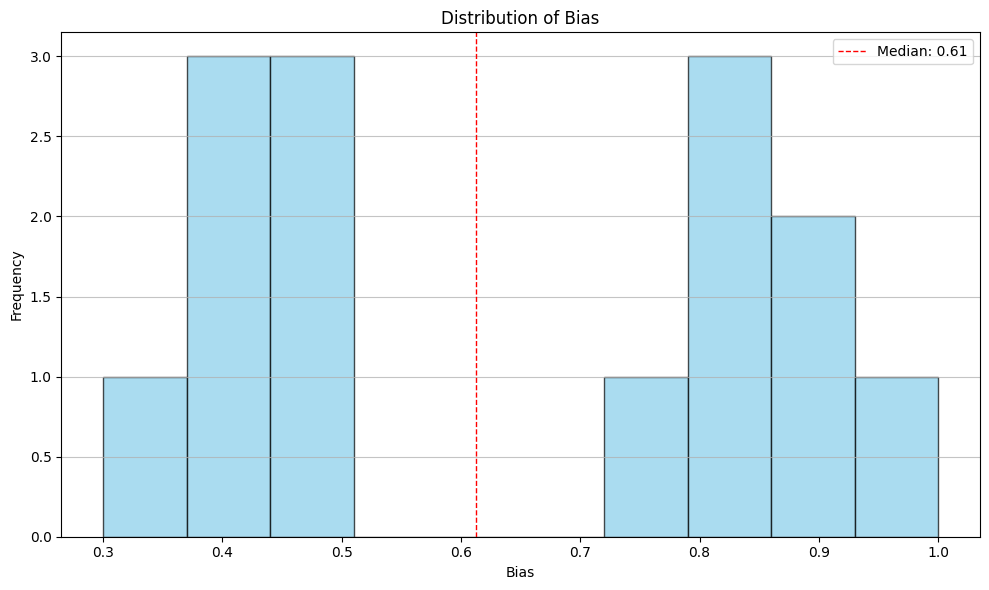

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
df = pd.read_csv('ground_data_bias.csv')  # Replace with your actual CSV file name

# Check if the 'Bias' column exists
if 'Bias' in df.columns:
    # Calculate the median of the Bias column
    median_bias = df['Bias'].median()
    print(f"The median of the Bias column is: {median_bias:.2f}")

    # Plot the distribution of the Bias column
    plt.figure(figsize=(10, 6))
    plt.hist(df['Bias'], bins=10, color='skyblue', edgecolor='black', alpha=0.7)
    plt.axvline(median_bias, color='red', linestyle='dashed', linewidth=1, label=f'Median: {median_bias:.2f}')
    plt.title('Distribution of Bias')
    plt.xlabel('Bias')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()
else:
    print("The 'Bias' column is not present in the CSV file.")

In [34]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('ipl_2025_schedule.csv')  # Replace with your actual CSV file name

# Check if the 'Venue' column exists
if 'Venue' in df.columns:
    # Get unique entries in the 'Venue' column
    unique_venues = df['Venue'].unique()

    # Display the unique venues
    print("Unique venues:")
    for venue in unique_venues:
        print(venue)
else:
    print("The 'Venue' column is not present in the CSV file.")

Unique venues:
Kolkata
Hyderabad
Chennai
Visakhapatnam
Ahmedabad
Guwahati
Mumbai
Lucknow
Bengaluru
Mohali
Jaipur
Delhi
Dharamsala
